## Acquistion function on a probability distribution

Let's say we have a classification problem for which it is more expensive to be class 0 than class 1.
How do we express this in a _probabilistic_ fashion?

Let's explore!

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

Let's say we have a probabilistic prediction, something that looks like the following distribution:

Text(0, 0.5, 'pdf(x)')

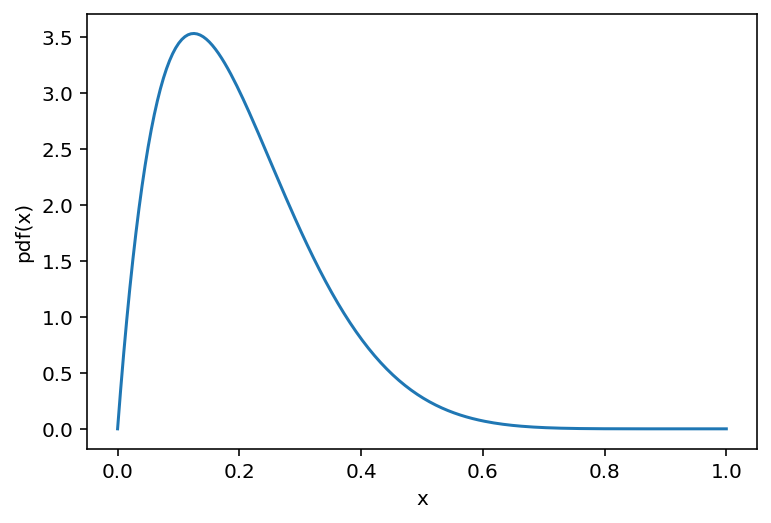

In [3]:
predictions_dist = beta(2, 8)
xs = np.linspace(0, 1, 200)

plt.plot(xs, predictions_dist.pdf(xs))
plt.xlabel("x")
plt.ylabel("pdf(x)")

How we _arrived_ at this probabilistic prediction, I am not going to go too deep. It could be a logistic regression model, or it could be a probabilistic neural network. What's more important is that we are able to calculate or simulate a distribution of values.

Let's also assume we have another probabilistic prediction that looks like the following:

Text(0, 0.5, 'pdf(x)')

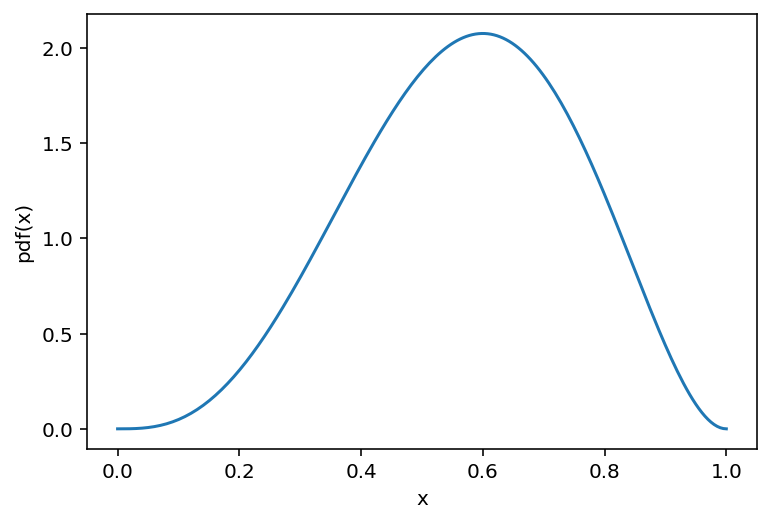

In [4]:
predictions_dist2 = beta(4, 3)
plt.plot(xs, predictions_dist2.pdf(xs))
plt.xlabel("x")
plt.ylabel("pdf(x)")

Now, let's also say we have a function that expresses how expensive it is to be wrong.

I'm going to use an arbitrary math function that is $e^{-x}$ on the interval (0, 1).

In [34]:
def cost_function(x): 
    return np.exp(-x)

Text(0, 0.5, 'cost(x)')

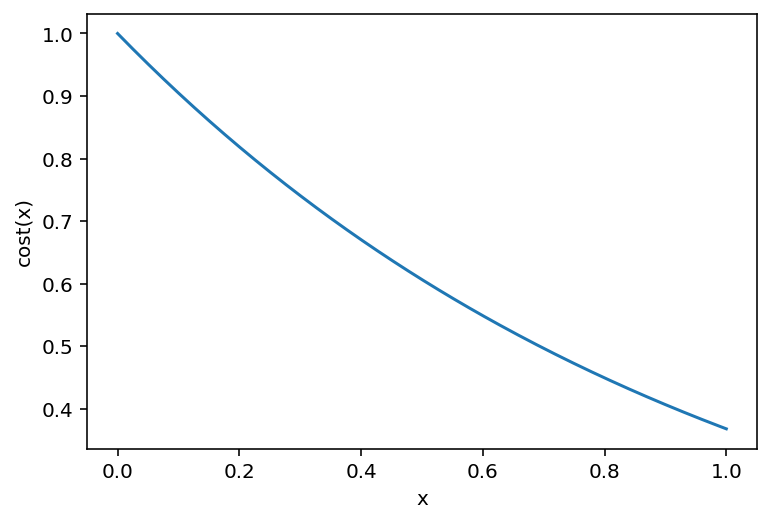

In [35]:
plt.plot(xs, cost_function(xs))
plt.xlabel("x")
plt.ylabel("cost(x)")

From this function, we can see that it is more expensive to be class 0 than it is to be class 1.

How do we calculate our expected cost, given our predictions? 

Here, we will rely on some known results from handling expectations.

## Expectation of a distribution

The expectation of a distribution is given as a definition as:

$$E[x] = \int(x.p(x))dx$$

where:

- $x$ is the value on the support of a distribution,
- $p(x)$ is the PDF of the given distribution,

It's basically taking a weighted average, as described on the [Wikipedia article on expected value](https://en.wikipedia.org/wiki/Expected_value).

Text(0, 0.5, 'x * p(x)')

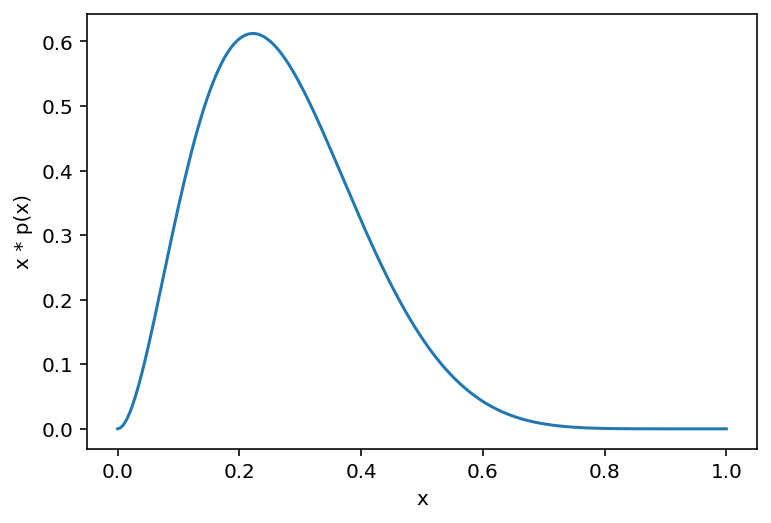

In [36]:
plt.plot(xs, xs * predictions_dist.pdf(xs))
plt.xlabel("x")
plt.ylabel("x * p(x)")

Now, computationally, integrals are basically sums. (This is something I learned from Allen Downey, it's a great idea to keep conceptually anchored.) So we can calculate the expectation of the distribution this way:

In [37]:
from scipy.integrate import quad

def expectation(dist, a: float=-np.inf, b:float = np.inf):
    return quad(lambda x: x * dist.pdf(x), a, b)

expected, err = expectation(predictions_dist, 0, 1)
expected, err

(0.2, 2.220446049250313e-15)

In [38]:
expected, err = expectation(predictions_dist2, 0, 1)
expected, err

(0.5714285714285713, 6.3441315692866076e-15)

This is equivalent to what SciPy stats does with the expectations.

In [57]:
# For first case:
predictions_dist.expect(lambda x: x)

0.2

In [58]:
predictions_dist2.expect(lambda x: x)

0.5714285714285713

$$f(E[x]) = E[f(x)] = \int_a^b f(x).p(x)dx$$

In plain English: A functional transform of the expectation, i.e. $f(E[x])$, is equivalent to taking the expectation over a transform of $x$, which gives us a path towards calculating it using integrals.

This is also a known result.

So... we can basically plug in our cost of being wrong into the `.expect()` function of a distribution:

In [76]:
quad(lambda x: cost_function(x) * predictions_dist.pdf(x), 0, 1)

(0.8245106369069453, 9.15390693142443e-15)

In [77]:
predictions_dist.expect(cost_of_being_wrong)

0.8245106369069453

In [78]:
quad(lambda x: cost_function(x) * predictions_dist2.pdf(x), 0, 1)

(0.5735082992536691, 6.367221186450379e-15)

In [79]:
predictions_dist2.expect(cost_of_being_wrong)

0.5735082992536691

All of this should make sense... our expected cost is lower based on our second distribution.

Can we visualize this?

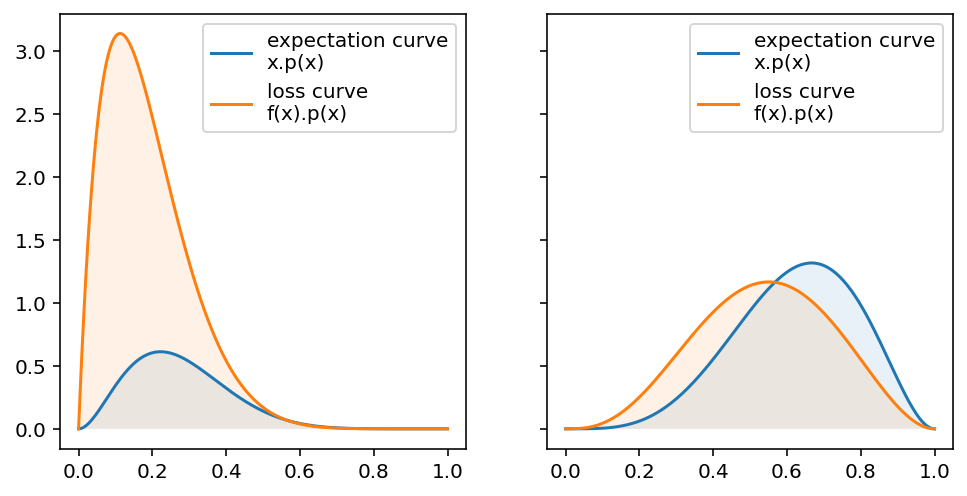

In [81]:
fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(xs, xs * predictions_dist.pdf(xs), label="expectation curve\nx.p(x)")
plt.fill_between(xs, 0, xs * predictions_dist.pdf(xs), alpha=0.1)
plt.plot(xs, cost_function(xs) * predictions_dist.pdf(xs), label="loss curve\nf(x).p(x)")
plt.fill_between(xs, 0, cost_function(xs) * predictions_dist.pdf(xs), alpha=0.1)
plt.legend()

plt.sca(ax[1])
plt.plot(xs, xs * predictions_dist2.pdf(xs), label="expectation curve\nx.p(x)")
plt.fill_between(xs, 0, xs * predictions_dist2.pdf(xs), alpha=0.1)
plt.plot(xs, cost_function(xs) * predictions_dist2.pdf(xs), label="loss curve\nf(x).p(x)")
plt.fill_between(xs, 0, cost_function(xs) * predictions_dist2.pdf(xs), alpha=0.1)
plt.legend()